## Reference

[Hands-on TensorBoard (TensorFlow Dev Summit 2017)](https://www.youtube.com/watch?v=eBbEDRsCmv4)

http://mourafiq.com/2016/08/10/playing-with-convolutions-in-tensorflow.html

http://deeplearning.stanford.edu/wiki/index.php/Feature_extraction_using_convolution

http://cs231n.github.io/understanding-cnn/

http://cs231n.github.io/convolutional-networks/#conv

[Visualizing parts of Convolutional Neural Networks using Keras and Cats](https://hackernoon.com/visualizing-parts-of-convolutional-neural-networks-using-keras-and-cats-5cc01b214e59)

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
mnist = input_data.read_data_sets('/tmp/MNIST_data', one_hot=True)

Extracting /tmp/MNIST_data/train-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data/t10k-labels-idx1-ubyte.gz


## Convolution

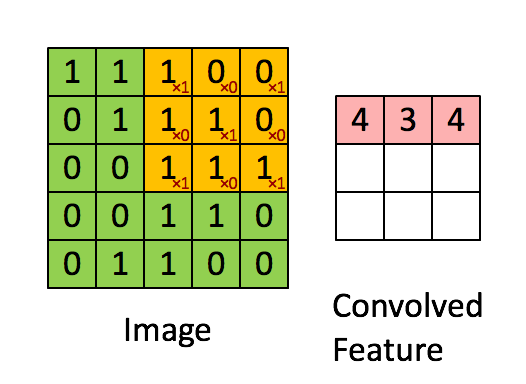

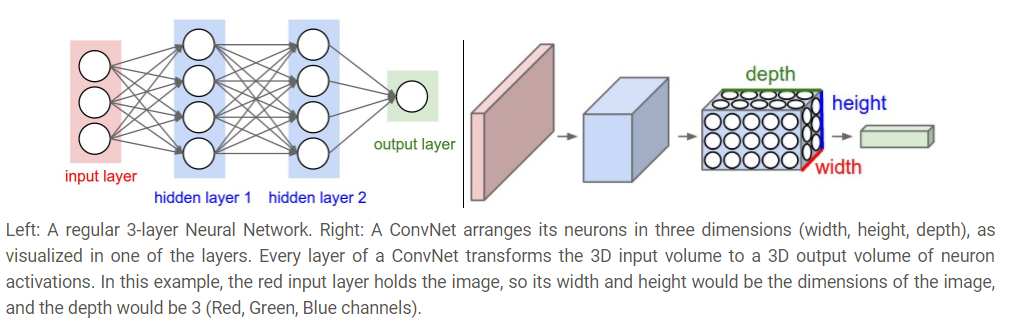

In [3]:
def conv_layer(input, size_in, size_out, name="conv", reuse=False):
    with tf.name_scope(name):
        with tf.variable_scope("vs", reuse=reuse):
#            w = tf.get_variable(initializer=tf.zeros([5, 5, size_in, size_out]), name="{}_W".format(name))
            w = tf.get_variable(initializer=tf.truncated_normal([5, 5, size_in, size_out], stddev=0.1), name="{}_W".format(name))
            b = tf.get_variable(initializer=tf.constant(0.1, shape=[size_out]), name="{}_B".format(name))
            conv = tf.nn.conv2d(input, w, strides=[1, 1, 1, 1], padding="SAME")
            act = tf.nn.relu(conv + b)

            return tf.nn.max_pool(act, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

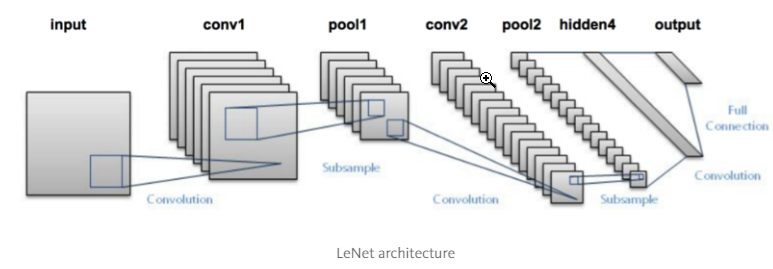

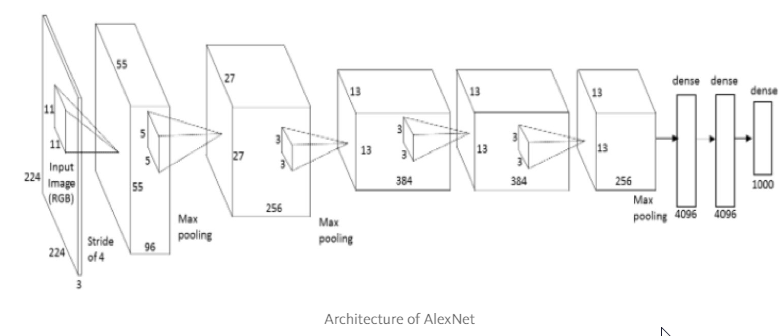

In [4]:
def fc_layer(input, size_in, size_out, name="fc"):
    with tf.name_scope(name):
        w = tf.Variable(tf.truncated_normal([size_in, size_out], stddev=0.1), name="W")
        b = tf.Variable(tf.constant(0.1, shape=[size_out]), name="B")
        act = tf.matmul(input, w) + b
        
        return act

In [5]:
def dropout_layer(input, keep_prob, name="dropout"):
    with tf.name_scope(name):
        return tf.nn.dropout(input, keep_prob)        

In [6]:
def to_image_tensor(weights):
    ''' weights shape = (5, 5, 1, 32)
    '''
    weights = tf.transpose(weights, perm=[3, 0, 1, 2])
    
    # scale weights to [0 255] and convert to uint8
    x_min = tf.reduce_min(weights)
    x_max = tf.reduce_max(weights)
    weights_0_to_1 = (weights - x_min) / (x_max - x_min)

    # Images that are represented using floating point values are expected to have values in the range [0,1). 
    # This op converts between data types, scaling the values appropriately before casting.
    weights_0_to_255_uint8 = tf.image.convert_image_dtype(weights_0_to_1, dtype=tf.uint8)
    
    return weights_0_to_255_uint8

In [7]:
def show_images(ndarr):
    ''' n * h * w * channels
    '''
    ndarr = ndarr.squeeze()
    
    cols = 16
    rows = ndarr.shape[0] // cols

    print("cols = {}, rows = {}".format(cols, rows))
    fig, axes = plt.subplots(figsize=(30, 4), nrows=rows, ncols=cols, sharex=True, sharey=True)

    axes = np.hstack(axes)
    for sample, ax in zip(ndarr, axes):
        ax.imshow(sample, cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)    
    
    plt.show()

train/Adam
step 0, training accuracy 0.04
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


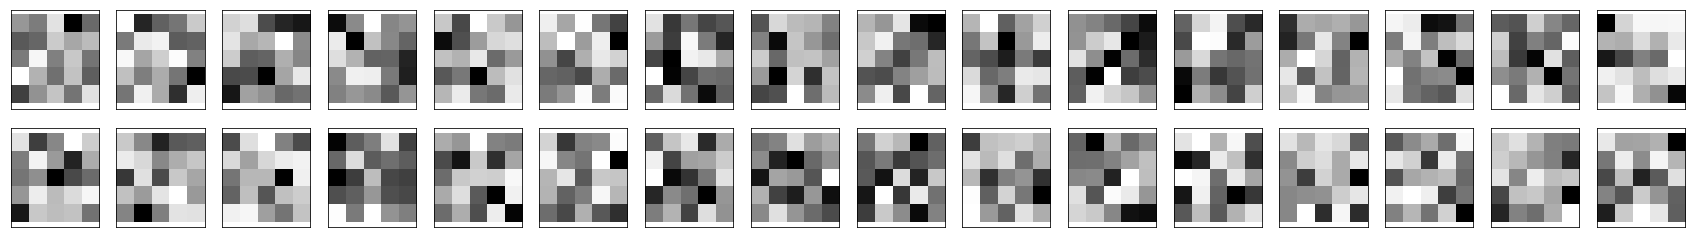

step 100, training accuracy 0.48
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


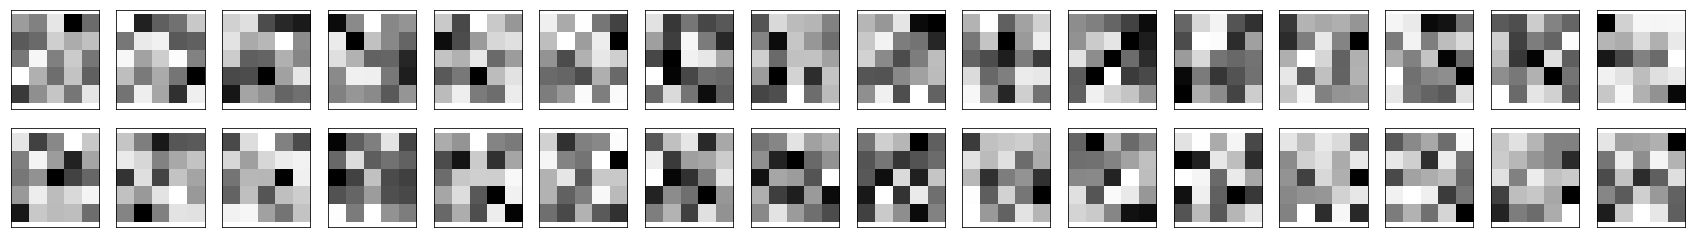

step 200, training accuracy 0.71
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


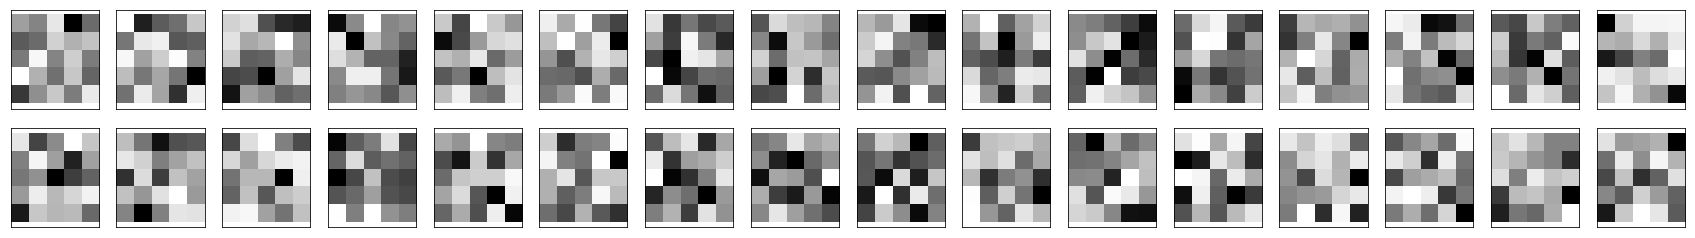

step 300, training accuracy 0.85
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


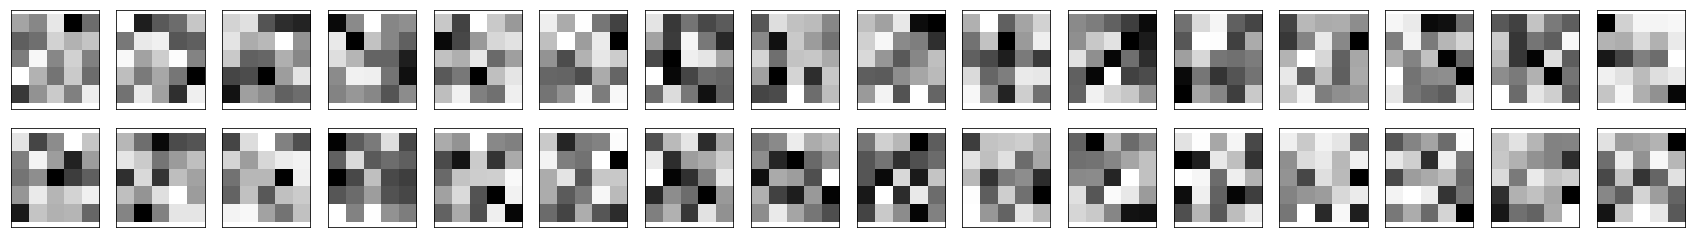

step 400, training accuracy 0.87
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


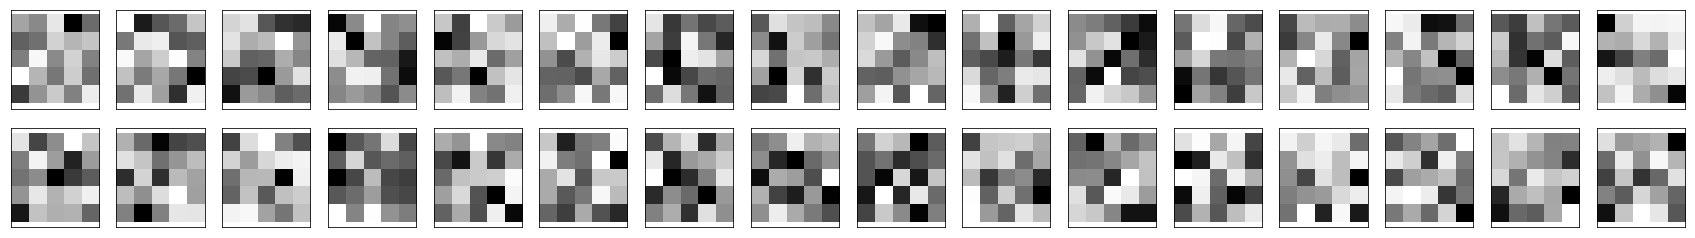

step 500, training accuracy 0.91
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


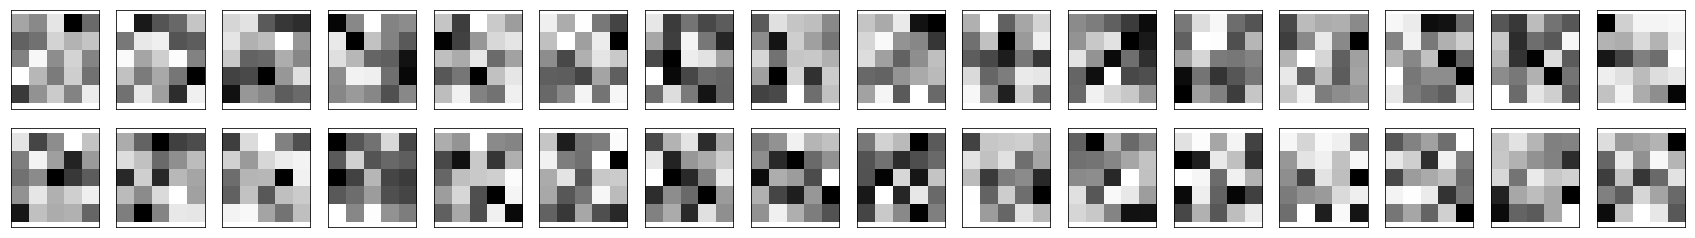

In [17]:
learning_rate = 1e-4

tf.reset_default_graph()
sess = tf.InteractiveSession()

# Default Graph
x = tf.placeholder(tf.float32, shape=[None, 784], name="x")
y = tf.placeholder(tf.float32, shape=[None, 10], name="labels")
keep_prob = tf.placeholder(tf.float32)

x_image = tf.reshape(x, [-1, 28, 28, 1])

tf.summary.image('input', x_image, 3)

conv1 = conv_layer(x_image, 1, 32, name="conv1")
conv2 = conv_layer(conv1, 32, 64, name="conv2")

flattened = tf.reshape(conv2, [-1, 7 * 7 * 64])
dropped = dropout_layer(flattened, keep_prob)
logits = fc_layer(dropped, 7 * 7 * 64, 10, "fc")

with tf.name_scope("xent"):
    xent = tf.reduce_mean(
               tf.nn.softmax_cross_entropy_with_logits(
               logits=logits, labels=y), name="xent")
    
with tf.name_scope("train"):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(xent)
    print(train_step.name)

with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

model_save_path = '/tmp/tf_mnist_cnn'

sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()

for i in range(501):
    batch = mnist.train.next_batch(100)
    
    if i % 100 == 0:
        training_accuracy = sess.run(accuracy, feed_dict={x: batch[0], 
                                                          y: batch[1],
                                                          keep_prob: 1.0})
    
        print('step %d, training accuracy %g' % (i, training_accuracy))
        
        # show
        with tf.variable_scope("vs", reuse=True):
            weights = tf.get_variable("conv1_W")
            bias = tf.get_variable("conv1_B")
            w = weights + bias
            print(w.shape)
            img_tensor = to_image_tensor(w)
            print(img_tensor.shape)
            data = img_tensor.eval(session=sess)
            show_images(data)            
        
        saver.save(sess, model_save_path, global_step=i, write_meta_graph=False)
    
    sess.run(train_step, feed_dict={x: batch[0], 
                                    y: batch[1],
                                    keep_prob: 0.5})
    
# save meta graph
saver.save(sess, model_save_path)

sess.close()

In [18]:
% ls $model_save_path*

/tmp/tf_mnist_cnn-200.data-00000-of-00001
/tmp/tf_mnist_cnn-200.index
/tmp/tf_mnist_cnn-300.data-00000-of-00001
/tmp/tf_mnist_cnn-300.index
/tmp/tf_mnist_cnn-400.data-00000-of-00001
/tmp/tf_mnist_cnn-400.index
/tmp/tf_mnist_cnn-500.data-00000-of-00001
/tmp/tf_mnist_cnn-500.index
/tmp/tf_mnist_cnn.data-00000-of-00001
/tmp/tf_mnist_cnn.index
/tmp/tf_mnist_cnn.meta

/tmp/tf_mnist_cnn:
tb/


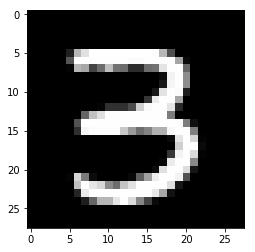

In [10]:
img = mnist.train.images[0]
plt.imshow(img.reshape(28, 28), cmap='Greys_r')

(1, 14, 14, 32)
cols = 16, rows = 2


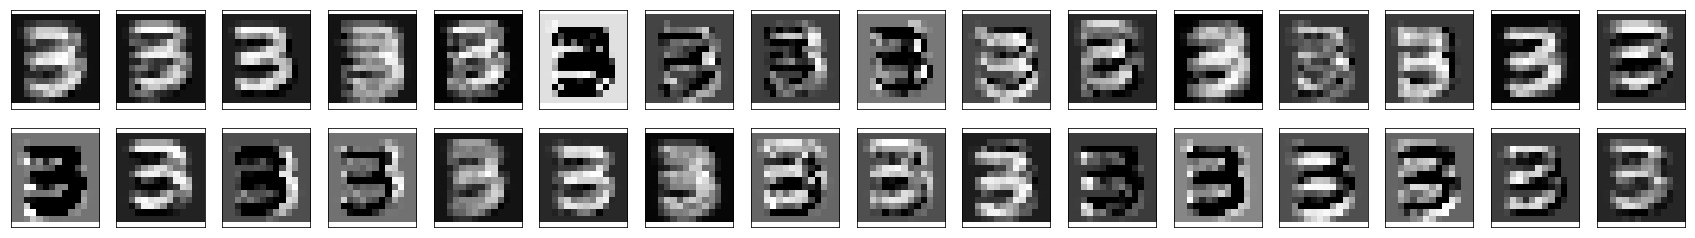

In [11]:
tf.reset_default_graph()

sess = tf.Session()

x = tf.placeholder(tf.float32, shape=[None, 784], name="x")
x_image = tf.reshape(x, [-1, 28, 28, 1])

# use previous trained weight and bias
conv1 = conv_layer(x_image, 1, 32, name="conv1", reuse=False)

sess.run(tf.global_variables_initializer())
ret = sess.run(conv1, feed_dict={x: np.expand_dims(img, axis=0)})
print(ret.shape)

show_images(ret.transpose(3,1,2,0))

sess.close()

conv1/vs/Relu:0
x:0
(1, 784)
INFO:tensorflow:Restoring parameters from /tmp/tf_mnist_cnn-200
(1, 28, 28, 32)
cols = 16, rows = 2


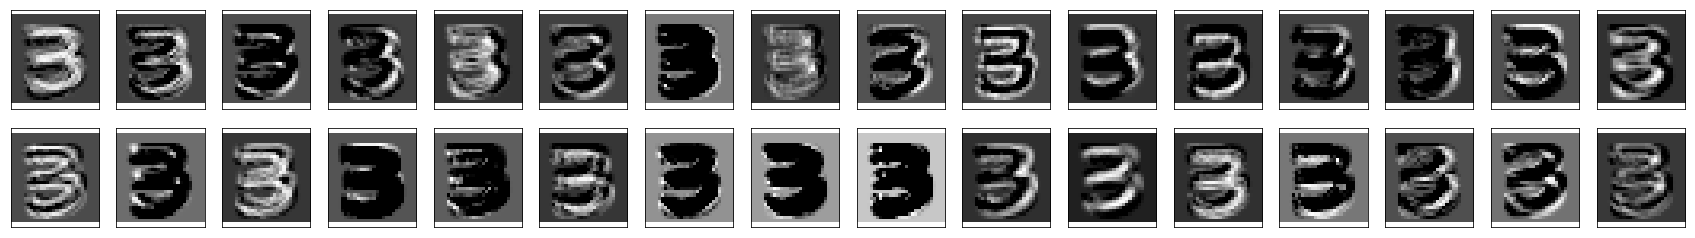

INFO:tensorflow:Restoring parameters from /tmp/tf_mnist_cnn-300
(1, 28, 28, 32)
cols = 16, rows = 2


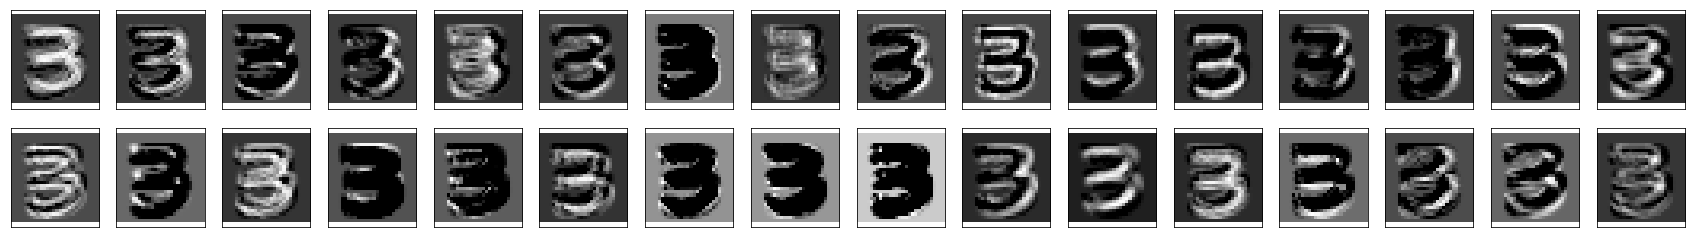

INFO:tensorflow:Restoring parameters from /tmp/tf_mnist_cnn-400
(1, 28, 28, 32)
cols = 16, rows = 2


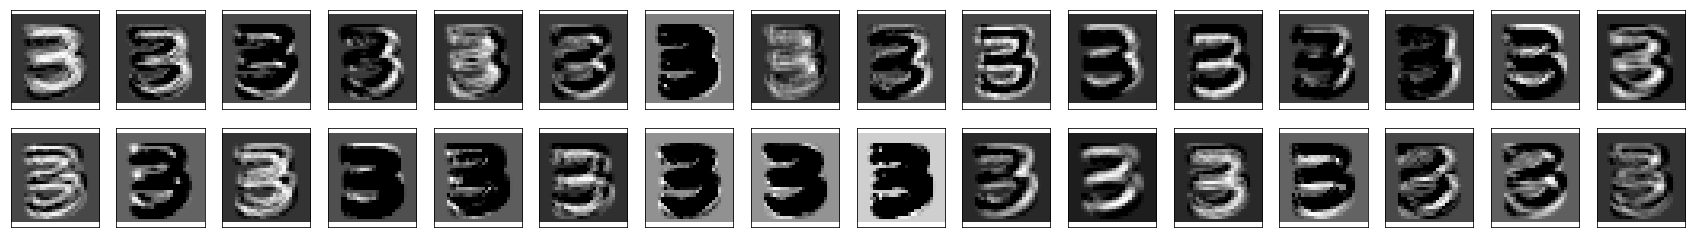

INFO:tensorflow:Restoring parameters from /tmp/tf_mnist_cnn-500
(1, 28, 28, 32)
cols = 16, rows = 2


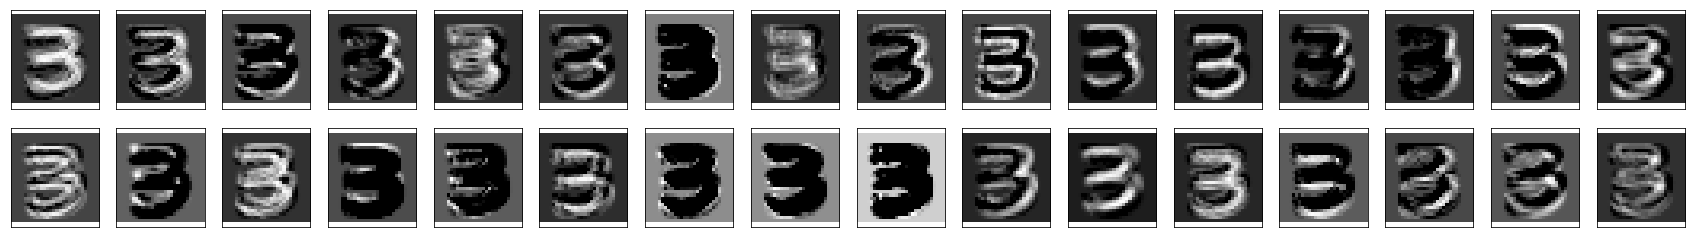

INFO:tensorflow:Restoring parameters from /tmp/tf_mnist_cnn
(1, 28, 28, 32)
cols = 16, rows = 2


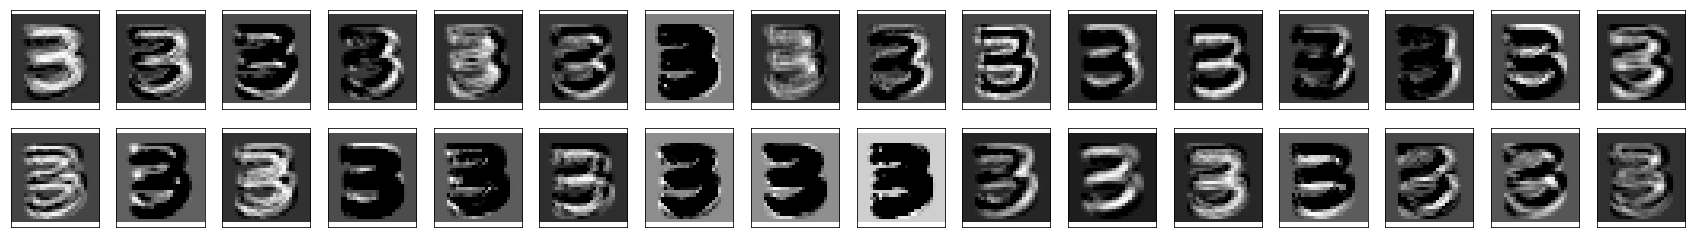

In [19]:
import os
import tensorflow as tf

tf.reset_default_graph()

sess = tf.InteractiveSession()

saver = tf.train.import_meta_graph('{}.meta'.format(model_save_path))
graph = tf.get_default_graph()

op_to_restore = graph.get_tensor_by_name("conv1/vs/Relu:0")
x = graph.get_tensor_by_name("x:0")
print(op_to_restore.name)
print(x.name)

img_exp = np.expand_dims(img, axis=0)
print(img_exp.shape)

folder = os.path.dirname(model_save_path)
files = filter(lambda fname: 'tf_mnist_cnn' in fname and fname.endswith(".index"), os.listdir(folder))

# latest checkpoints only
#tf.train.latest_checkpoint(folder)

for f in sorted(files):
    ckpt_name = os.path.splitext(f)[0]
    
    saver.restore(sess, os.path.join(folder,  ckpt_name))

    #ret = sess.run(op_to_restore, feed_dict={'x:0': img_exp}) 
    #is equivalent to 
    ret = sess.run(op_to_restore, feed_dict={x: img_exp})

    print(ret.shape)
    show_images(ret.transpose(3,1,2,0))

sess.close()